<a href="https://colab.research.google.com/github/Peritec-Corp/IoTSolution/blob/main/%E3%83%89%E3%83%A1%E3%82%A4%E3%83%B3%E7%99%BB%E9%8C%B2%E3%83%BBSSL%E8%AA%8D%E8%A8%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SSL認証
##目次
1. ドメイン取得
2. CSR作成
3. メールサーバー立ち上げ
4. アップロード
5. サーバーへ適用
---

---
# 1. ドメイン取得

お名前.comを使用したドメイン取得方法について記載します。

https://www.onamae.com/

1. 取得したいドメインを入力し検索します。

> 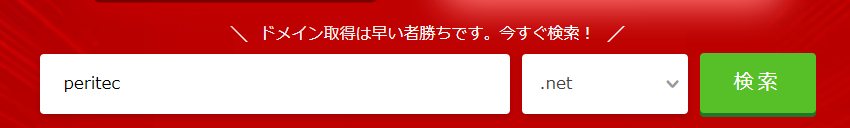

2. ドメインが空いていることを確認し、「〇」を選択します。

> 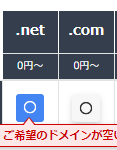

3. 利用しないを選択します。

> 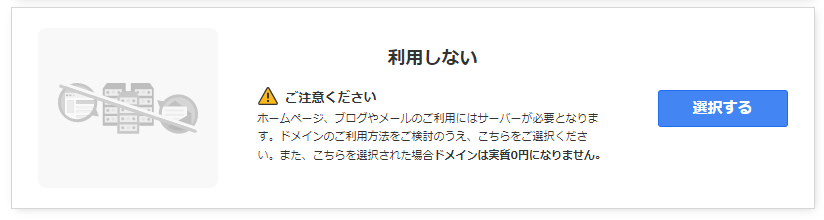

4. 「お申込みへ進む」をクリックします。この際、アカウント登録を行います。

5. 案内に従って、お支払いをします。
> 基本的に、1年間であれば無料となります。\
クレジット登録が必要となります。

6. ドメインとグローバルIPアドレスの紐づけを行います。


> [ネームサーバーの設定]の[ドメインDNS設定]をクリックします。



> 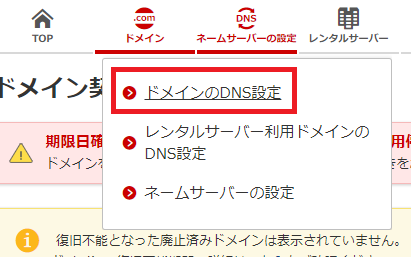

7. 変更したいドメインを選択し、「次へ」をクリックします。

> 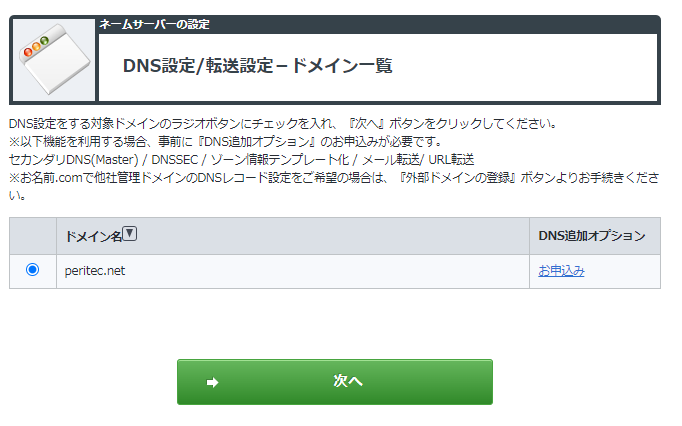

8. 「DNSレコード設定を利用する」をクリックします。

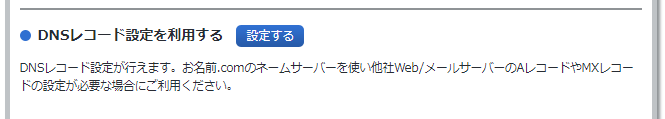


9. DNSレコードを設定して追加します。(ホスト名は空欄でも大丈夫です)

> 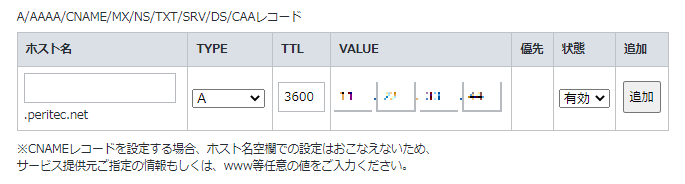

10. 「確認画面へ進む」をクリックします。
11. 内容を確認し、「設定する」をクリックします。

12. コマンドプロンプトで、pingが通れば設定が正しく反映されています(設定が反映されるまで少し時間がかかるようです)。

> 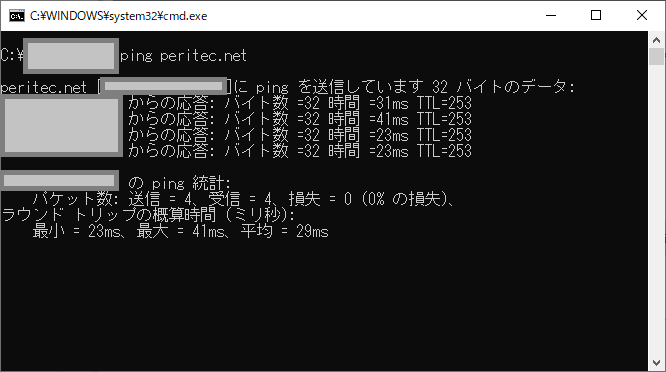

---
# 2. CSR作成

CSR作成手順について記載します(参考：https://jp.globalsign.com/support/ssl/manual-csr/nginx.html)。

1. nginxのconfファイルがある場所に移動します。\
　一般的には　/etc/nginx/　です。\
　今回は、Dockerのコンテナ上に配置したいため、以下のパスに移動します。\
　/nginx-nr/nginx

2. keyファイルを作成します。

```
peritec@iotschool:~/nginx-nr/nginx$ openssl genrsa -des3 -out ./ssl.peritec.net.key 2048
```

3. csrファイルを作成します。


```
/nginx-nr/nginx$ openssl req -new -key ./ssl.peritec.net.key -out ./ssl.peritec.net.csr
```

> フィールドを入力します。

4. lsコマンドを使用して、ファイルが生成されていることを確認します。

---
# 3. メールサーバーの立ち上げ
名前.comよりSSL認証を発行する場合、承認メールを今回取得したドメインのメールアドレスで受信する必要があります。そのため、承認メール受信用のメールサーバーを立ち上げる必要があるので、その手順を記載します。
(名前.com以外でSSL認証を取得し、指定のメールアドレスが必要ない場合は、本項目は実施しなくて良いです)

参照：https://qiita.com/qiiChan/items/a44cfa4af283917a8f6e

1. 参照先の通りに、サーバー上でコマンドを実行する。
(以下引用)

> メールアドレスと、パスワードを任意のものに置き換えて設定して下さい。


- プロジェクトフォルダ作成\
最初にプロジェクトフォルダを作成して下さい。
```
  #プロジェクトフォルダ作成
  $ mkdir project_mail

  #プロジェクトフォルダに移動
  $ cd project_mail
```

- モジュール入手\
次にモジュールを入手します。
```
  $ wget https://raw.githubusercontent.com/tomav/docker-mailserver/master/setup.sh

  $ wget https://raw.githubusercontent.com/tomav/docker-mailserver/master/docker-compose.yml

  $ wget https://raw.githubusercontent.com/tomav/docker-mailserver/master/mailserver.env

  $ curl -o .env https://raw.githubusercontent.com/tomav/docker-mailserver/master/compose.env

  $ chmod a+x ./setup.sh

  $ ls -la
```

- フォルダ作成\
フォルダが作成されていない場合は、作成して下さい。
```
  #フォルダ作成
  $ mkdir docker-data/dms/config
  $ mkdir docker-data/dms/mail-data
  $ mkdir docker-data/dms/mail-logs
  $ mkdir docker-data/dms/mail-state
```

- 環境変数設定
.envにドメイン名を追記して下さい。
一応、ここで設定しなくても、メールアドレス登録時に自動的に登録されるっぽいです。
今回はローカルドメインを指定するので、自分自身へのメール送受信のみ可能になります。
```
DOMAINNAME=domain.local
```
- ポート使用プロセスの停止
 25番ポートを使用しているプロセスがあったら、停止して下さい。

```
 #使用ポート表示（sudo使用）
 $ sudo lsof -i -P | grep "LISTEN"
 
 #25番ポートのプロセス停止
 $ kill プロセスid
```

- コンテナ設定
コンテナを起動して、メールアドレスの登録などを行います。
ここで、登録するメールアドレスは、sample_mail@domain.local、パスワードは、mailpassになります。メールアドレスは、複数登録可能です。
```
  #docker-compose起動
  $ docker compose up -d

  #メールアドレス登録
  $ sudo ./setup.sh email add sample_mail@domain.local mailpass

  #ポストマスター登録
  $ sudo ./setup.sh alias add postmaster@domain.local sample_mail@domain.local

  #dkim設定
  $ sudo ./setup.sh config dkim

  #登録アドレス一覧表示
  $ sudo ./setup.sh email list

  #登録ポストマスター一覧表示
  $ sudo ./setup.sh alias list

  #docker-compose停止
  $ docker-compose down

  #docker-compose起動
  $ docker-comopse up -d

  #ログ確認
  $ docker-comopse logs
```

- 補足
補足ですが、./setup.shのコマンド一覧は、下記になります。詳細は、こちらやこちらを参照してください。

```
#email:
    ./setup.sh email add <email> <password>
    ./setup.sh email update <email> <password>
    ./setup.sh email del <email>
    ./setup.sh email restrict <add|del|list> <send|receive> [<email>]
    ./setup.sh email list

#alias:
    ./setup.sh alias add <email> <recipient>
    ./setup.sh alias del <email> <recipient>
    ./setup.sh alias list

#config:
    ./setup.sh config dkim <keysize> (default: 2048)
    ./setup.sh config ssl

#debug:
    ./setup.sh debug fetchmail
    ./setup.sh debug show-mail-logs
    ./setup.sh debug inspect
    ./setup.sh debug login <commands>
```

- ポートを開く

```
使用しているサーバのポートを開きます。
開くポートの番号は、下記になります。

143
587
25
以上で、設定は終了になります。
```

2. Thunderbirdを使用して、メールの送受信を確認する。
- Thunderbirdを他のPCにダウンロード・インストールする
- アカウント設定を行う。


```
メールアドレス　:　sample_mail@domain.local
パスワード　　　:　mailpass

プロトコル : IMAP

受信メール
　　サーバ名　　：　サーバのIPアドレス、または独自ドメイン名
　　ポート番号　：　143
　　暗号化方法　：　なし
　　認証方式　　：　通常のパスワード認証

送信メール
　　サーバ名　　：　サーバのIPアドレス、または独自ドメイン名
　　ポート番号　：　587
　　暗号化方法　：　なし
　　認証方式　　：　通常のパスワード認証

実際に送受信出来たら、設定成功です。
```



---
# 4. アップロード
CSRファイルをアップロードします。



1. お名前.comをページを表示します。
2. [SSL証明書]の[利用ドメインSSL証明書発行]をクリックします。

>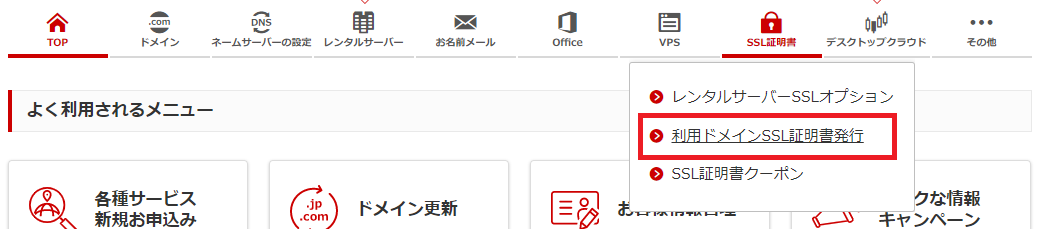

3. SSL証明書を発行したいドメインを選択し、「次へ」をクリックします。
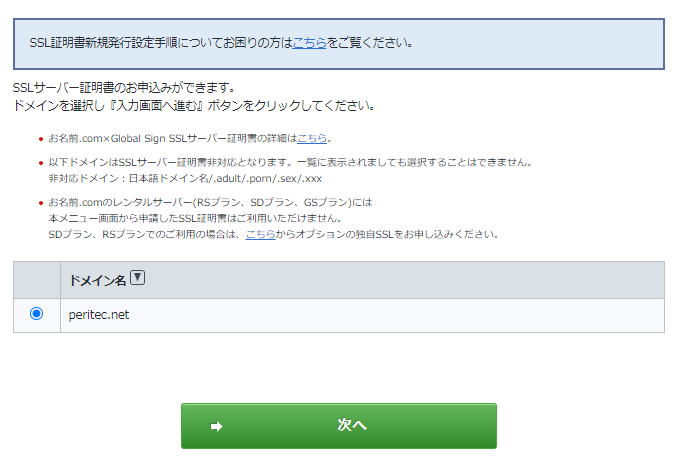

4. CSR情報をCSR欄に貼り付けます。「次へ」ボタンをクリックします。

> 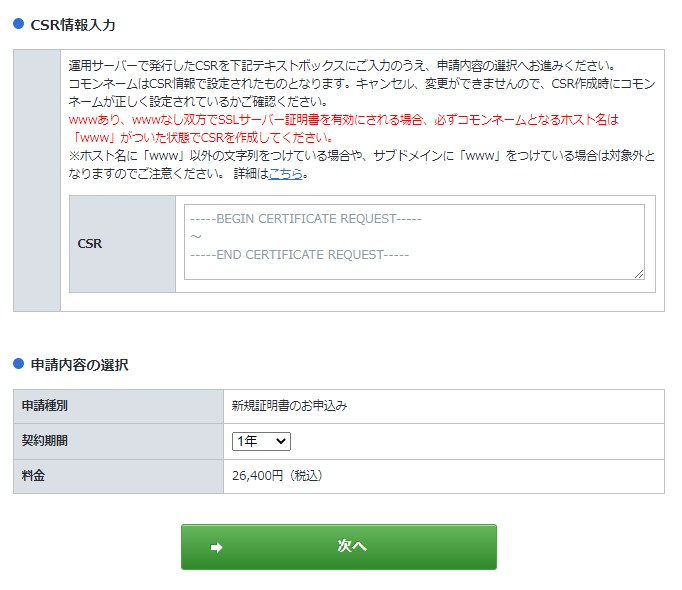


5. 認証メールを受信したいメールアドレスを設定します(admin@peritec.netなど)。
6. 案内に従います。SSL認証の支払いがまだの場合は、ここで支払いを行います。